In [3]:

import os
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import torch
from omegaconf import OmegaConf, DictConfig
import hydra
from bridge.langevin import Langevin

# 用于初始化 Hydra 并且合成配置的函数
def init_hydra():
    with hydra.initialize(config_path="conf", version_base="1.2"):
        # 这里我们使用 compose 而不是 hydra.main
        cfg = hydra.compose(config_name="config")
        return cfg

# 执行代码
cfg = init_hydra()
# cfg.checkpoint_run = True
# cfg.checkpoint_it = 20
# cfg.checkpoint_pass = None
# cfg.sample_checkpoint_f = "/home/ljb/diffusion_schrodinger_bridge/experiments/2024-02-20/main/model=Basic/16-29-22/checkpoints/net_f_20_10000.ckpt"
# cfg.sample_checkpoint_b = "/home/ljb/diffusion_schrodinger_bridge/experiments/2024-02-20/main/model=Basic/16-29-22/checkpoints/net_b_20_10000.ckpt"
# cfg.checkpoint_f = "/home/ljb/diffusion_schrodinger_bridge/experiments/2024-02-20/main/model=Basic/16-29-22/checkpoints/net_f_20_10000.ckpt"
# cfg.checkpoint_b = "/home/ljb/diffusion_schrodinger_bridge/experiments/2024-02-20/main/model=Basic/16-29-22/checkpoints/net_b_20_10000.ckpt"

In [4]:
from bridge.runners.ipf import IPFSequential
ipf = IPFSequential(cfg)

net_f: 26M
net_b: 26M


/home/ljb/miniforge3/envs/new/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [5]:
bnew_dl = ipf.new_cacheloader('b', 100, cfg.ema)
fnew_dl = ipf.new_cacheloader('f', 1, cfg.ema)

Cache size: torch.Size([200000, 2, 2])
Load time: 0.5790700912475586
Cache size: torch.Size([200000, 2, 2])
Load time: 0.49994444847106934


In [6]:
init_sample = next(ipf.cache_init_dl)[0]
x, out, step = ipf.langevin.record_init_langevin(init_sample)
print(x.shape, step.shape)
# store x, out
x = x.unsqueeze(2)
out = out.unsqueeze(2)
batch_data = torch.cat((x, out), dim=2)
flat_data = batch_data.flatten(start_dim=0, end_dim=1)
flat_steps = step.flatten(start_dim=0, end_dim=1)

flat_data.shape, flat_steps.shape

torch.Size([10000, 20, 2]) torch.Size([10000, 20, 1])


(torch.Size([200000, 2, 2]), torch.Size([200000, 1]))

In [7]:
plt.scatter(*init_sample.T.detach().cpu().numpy())
plt.show()
plt.scatter(*x[:,0].T)
plt.show()
# for i in range(20):
#     plt.scatter(*x_tot[:,0].T.detach().cpu().numpy())
#     plt.show()

/tmp/ipykernel_2966867/950835264.py:3: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.scatter(*x[:,0].T)


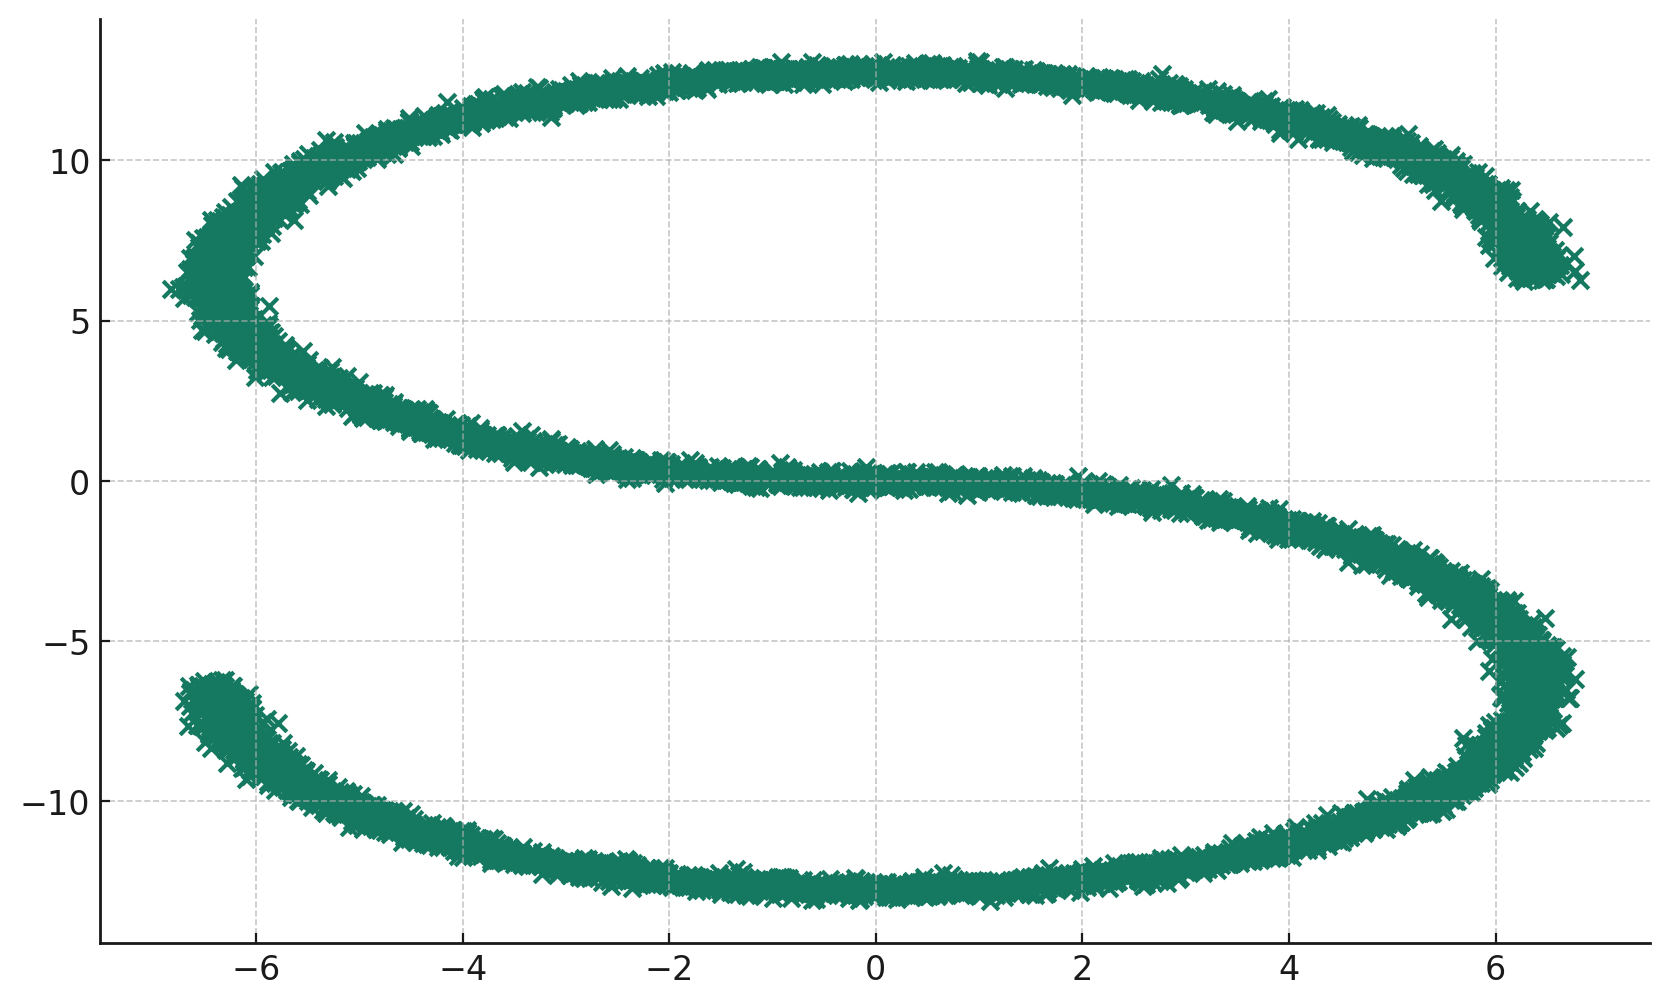

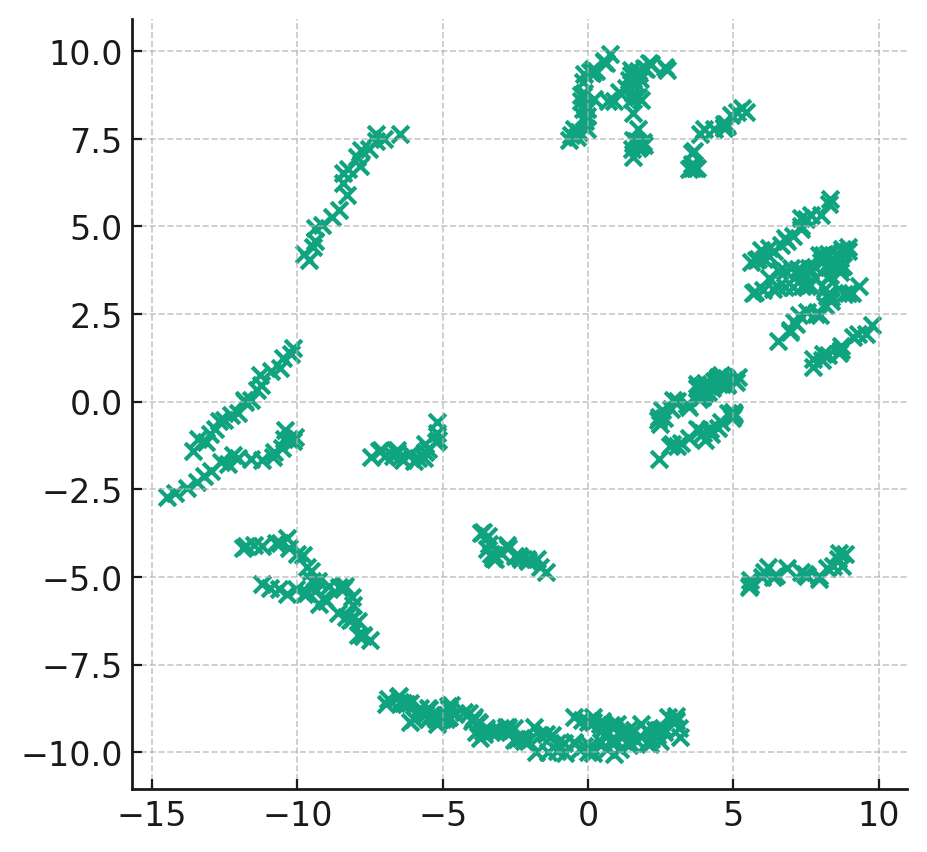

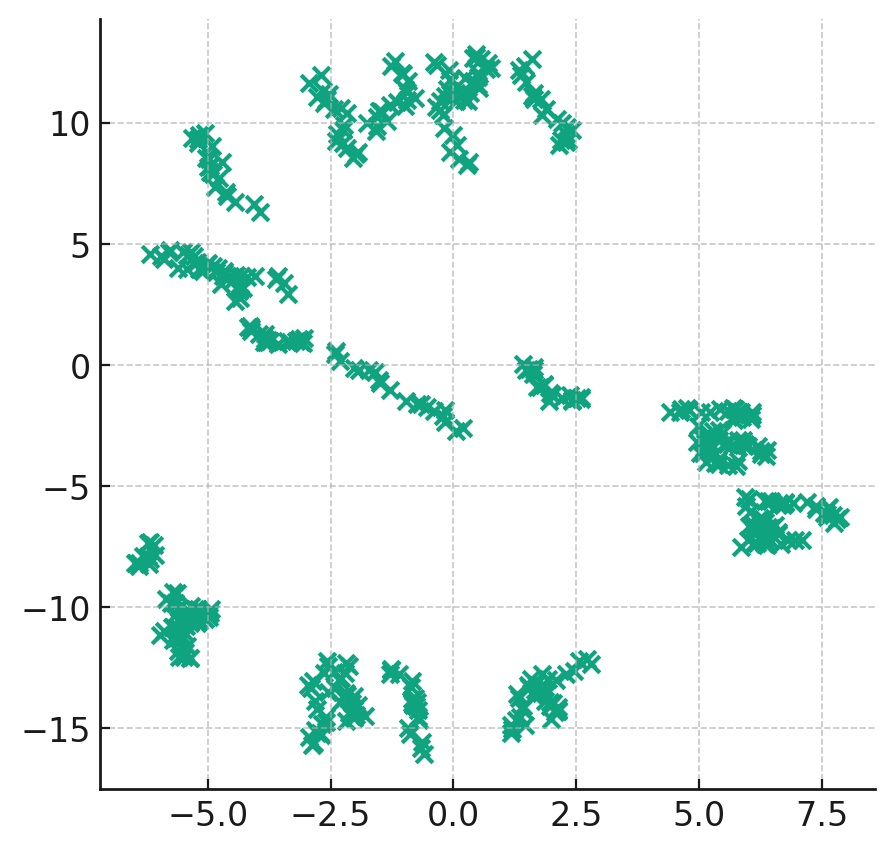

In [8]:
%matplotlib inline

x, out, steps = next(fnew_dl)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(*x.T)
fig.show()

x, out, steps = next(bnew_dl)
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(*x.T)
fig.show()

In [9]:
langevin = ipf.langevin
x = torch.randn(512,2)

In [52]:
# x_tot, out, steps_expanded = langevin.record_langevin_seq(
#                         ipf.net['b'], x, ipf_it=20, sample=True)
langevin.mean_final = 5
langevin.var_final = 0.2
x_tot, out, steps_expanded = langevin.record_init_langevin(
                             x)


In [53]:
x_tot.shape

torch.Size([512, 20, 2])

In [54]:
import numpy as np
def draw_gaussian2d_base(fig, ax, bridge,ts, show_rate=1., color=None):
    if show_rate < 1.:
        # generate random indices
        indices = np.random.choice(bridge.shape[1], int(bridge.shape[1]*show_rate), replace=False)
        bridge = bridge[:, indices, :]
    
    ax.scatter(bridge[0, :, 0].numpy(), bridge[0, :, 1].numpy(), ts[0].numpy(), c='r' if color is None else color, label='Start', s=2, alpha=0.3)

    # # 为每个样本绘制bridge
    for i in range(bridge.shape[1]):
        x = bridge[:, i, 0].numpy()  # X坐标
        y = bridge[:, i, 1].numpy()  # Y坐标
        z = ts.numpy()               # 时间作为Z坐标
        ax.plot(x, y, z, 'gray', label=f'Sample {i+1}', alpha=0.1, linewidth=1)        
    
    ax.scatter(bridge[-1, :, 0].numpy(), bridge[-1, :, 1].numpy(), ts[-1].numpy(), c='g' if color is None else color, label='End', s=2, alpha=0.3)
    
    # 添加标签和图例
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Time')

    return fig, ax

def draw_gaussian2d(bridge,ts, show_rate=1.):
    # 创建3D图形
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    draw_gaussian2d_base(fig, ax, bridge, ts, show_rate)
    return fig

n_t = x_tot.shape[1]
test_ts = torch.arange(0,1,1/n_t)
print(test_ts.shape)
draw_gaussian2d(x_tot.detach().permute(1,0,2), test_ts, show_rate=0.1).show()
from pathlib import Path
import shutil
import imageio
def save_gif_frame(bridge, save_path=None, name='brownian_bridge.gif', bound=10):
    assert save_path is not None, "save_path cannot be None"
    save_path = Path(save_path)
    bridge = bridge[:, :, :].numpy()  # 降低采样率

    temp_dir = save_path / 'temp'
    if temp_dir.exists():
        shutil.rmtree(temp_dir)
    temp_dir.mkdir(exist_ok=True)
    frame = 0
    
    color_map = -np.sqrt(bridge[0, :, 0]**2 + bridge[0, :, 1]**2)
    for i in range(bridge.shape[0]):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.clear()
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(-bound, bound)
        ax.set_ylim(-bound, bound)
        x = bridge[i, :, 0]  # 注意：
        y = bridge[i, :, 1]  # 注意：
        
        ax.scatter(x, y, c=color_map, alpha=1, s=10)
        fig.savefig(save_path / 'temp' / f'{frame:03d}.png', dpi=100)
        frame += 1
        fig.show()
        plt.close('all')
    frames = []
    for i in range(bridge.shape[0]):
        frame_image = imageio.imread(save_path / 'temp' / f'{i:03d}.png')
        frames.append(frame_image)
    imageio.mimsave(save_path / name, frames, duration=0.2)
    if temp_dir.exists():
        shutil.rmtree(temp_dir)
        
save_gif_frame(x_tot.detach().permute(1,0,2), save_path='.', name='brownian_bridge.gif', bound=10)

torch.Size([20])


/tmp/ipykernel_2966867/1499166587.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame_image = imageio.imread(save_path / 'temp' / f'{i:03d}.png')


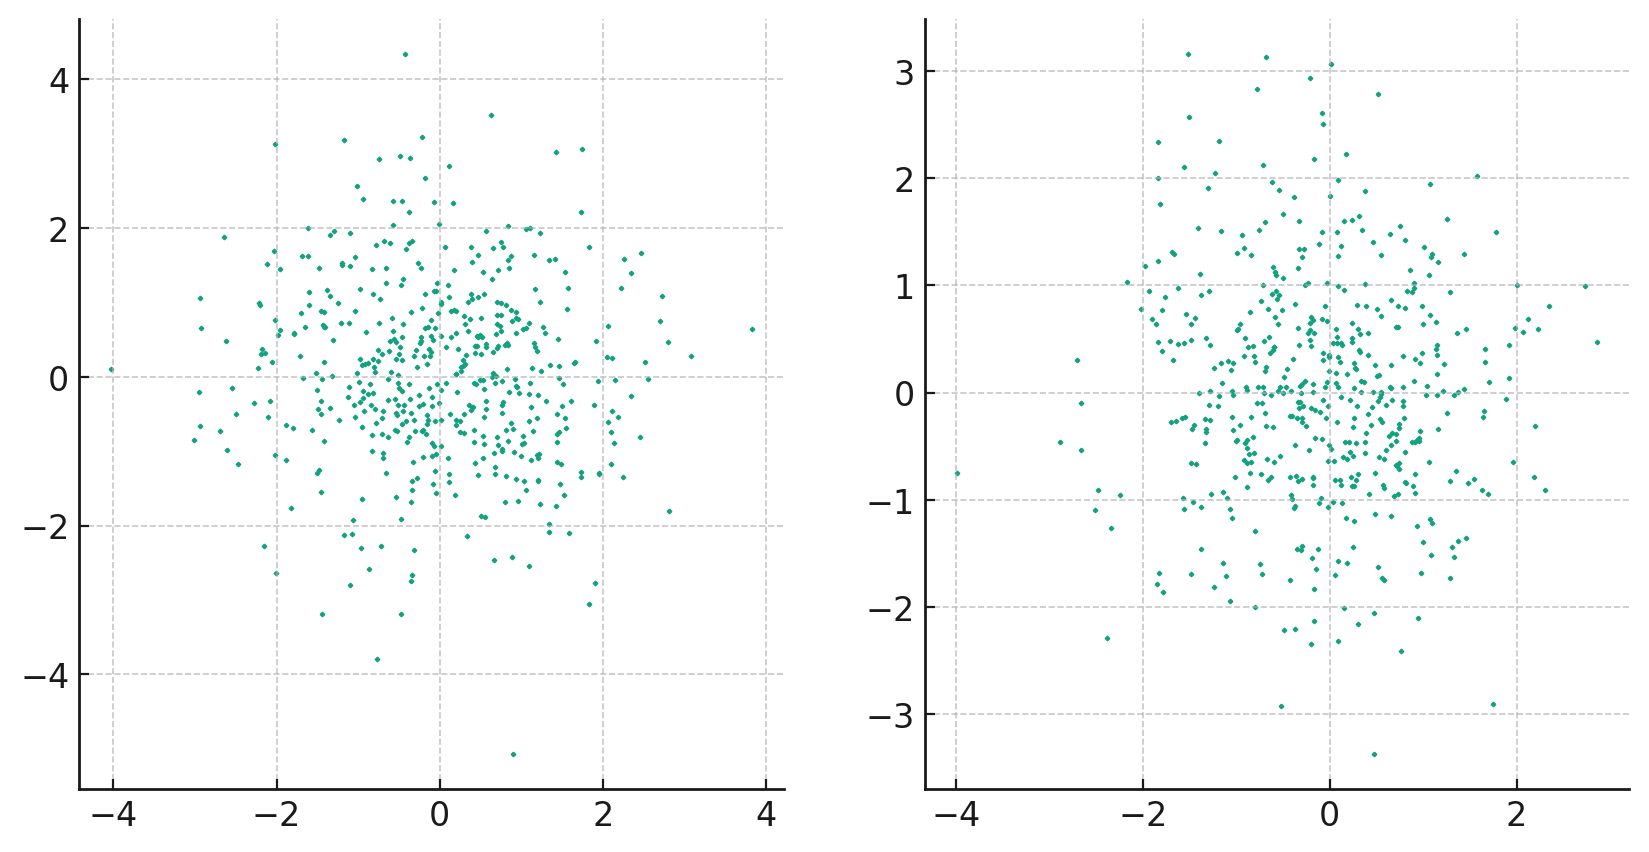

In [39]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(*x_tot[:,-1].detach().numpy().T, s=1)
axs[1].scatter(*x.detach().numpy().T, s=1)
fig.show()